In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from sklearn.model_selection import learning_curve
from sklearn import svm
from sklearn.externals import joblib
import sklearn_evaluation.plot as skplot
import matplotlib.pyplot as plt
import os
import os.path
import glob
import numpy as np

np.random.seed(1)

#GPU Config
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
#|-dataset
#   |-splicing
#       |-splicing-01.png
#   |-normal
#       |-normal-01.png

imagedir = "/path/data/base/splited/"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'ppm'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tClass: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

/home/tiagojc/splicing/source-code
Label: 0	Class:          NORMAL	Number of images: 25
Label: 1	Class:        SPLICING	Number of images: 25
Processing images ...
Images processed: 50


In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
print("Extracting features from ResNet50 layers ...")
resnet50features = base_model.predict(X)

Extracting features from ResNet50 layers ...


In [10]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds
skf = StratifiedKFold(kfold, shuffle=True, random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0
for index in skf.split(X, y):
    skfind[cnt] = index
    cnt += 1

In [11]:
# Training top_model and saving min training loss weights
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
for i in range(kfold):
    
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = resnet50features[train_indices]
    y_train = y[train_indices]
    X_test = resnet50features[test_indices]
    y_test = y[test_indices]
    
    C_range = np.logspace(-2, 10, 13)
    gamma_range = np.logspace(-9, 3, 13)
    param_grid = dict(C=C_range)
    cv = PredefinedSplit(train_indices)
    grid_model = GridSearchCV(svm.LinearSVC(), param_grid=param_grid, verbose=0, n_jobs=-1)
    grid_model.fit(X_train,y_train)  # Training 
    
    print("Best parameters: %s - score: %0.4f" % (grid_model.best_params_, grid_model.best_score_))
    
    
    top_model = svm.LinearSVC(C=grid_model.best_params_['C'])
    top_model.fit(X_train,y_train)  # Training
    y_pred = top_model.predict(X_test)  # Testing
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Best parameters: {'C': 0.01} - score: 0.9500
[0] Test acurracy: 0.8000
Best parameters: {'C': 0.01} - score: 0.8250
[1] Test acurracy: 1.0000
Best parameters: {'C': 0.01} - score: 0.8500
[2] Test acurracy: 1.0000
Best parameters: {'C': 0.01} - score: 0.9250
[3] Test acurracy: 0.9000
Best parameters: {'C': 0.01} - score: 0.8500
[4] Test acurracy: 0.9000


In [12]:
# Fit the model that will be trained for cross-dataset
nsamples,ndimensions = resnet50features.shape
train_indices = np.array(range(0,nsamples))
X_train = resnet50features[train_indices]
y_train = y[train_indices]
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(C=C_range)
grid_model = GridSearchCV(svm.LinearSVC(), param_grid=param_grid, verbose=0, n_jobs=-1)
grid_model.fit(X_train,y_train)  # Training 
print("Best parameters: %s - score: %0.4f" % (grid_model.best_params_, grid_model.best_score_))
top_model_cross = svm.LinearSVC(C=grid_model.best_params_['C'])
top_model_cross.fit(X_train,y_train)  # Training
joblib.dump(top_model_cross, 'ResNet-SVM_LINEAR-DSI-IIC.pkl', compress=9)

Best parameters: {'C': 0.01} - score: 0.9200


['ResNet-SVM_LINEAR-DSI-IIC.pkl']

In [13]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9200


Plotting the confusion matrix


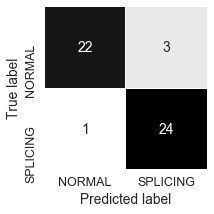

In [14]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


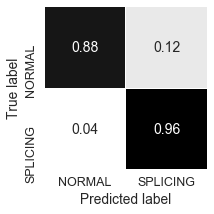

In [15]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [19]:
# plt.rcParams['image.cmap'] = 'Paired'
# skplot.grid_search(grid_model.grid_scores_, kind='bar')
# figure = plt.gcf()
# figure.set_size_inches(24, 9)
# plt.show()

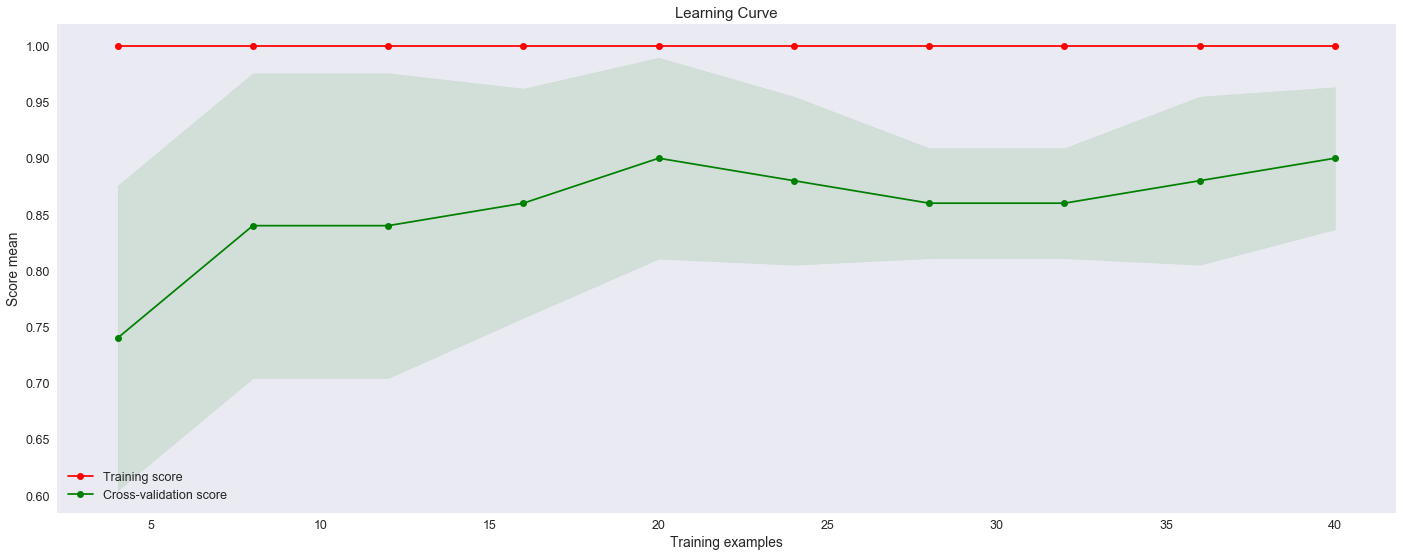

In [20]:
plt.style.use('seaborn-whitegrid')
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
svm_model = svm.LinearSVC(C=grid_model.best_params_['C'])
train_sizes = np.linspace(.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(svm_model, resnet50features, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
figure = plt.gcf()
figure.set_size_inches(24, 9)
skplot.learning_curve(train_scores, test_scores, train_sizes)
plt.show()